# Import Dependencies

In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
gpus =  tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [192]:
data_dir = 'drive/MyDrive/projects/GarbageDatasets'
def number_samples(data_dir = data_dir):
  for i in os.listdir(data_dir):
    categorie = os.listdir(os.path.join(data_dir, i))
    print(f'{i}: {len(categorie)} samples')
number_samples()

plastic: 482 samples
paper: 594 samples
metal: 410 samples
glass: 501 samples
cardboard: 403 samples
trash: 137 samples


# Load Data

In [194]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   image_size=(256, 256),
                                                   batch_size=32,
                                                   label_mode='categorical')

Found 2527 files belonging to 6 classes.


# Preprocessing

In [193]:
#Scale Data
data = data.map(lambda x,y: (x/255, y))

In [11]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [12]:
train_size = int(len(data) * 0.7)
val_size   = int(len(data) * 0.2) + 1
test_size  = int(len(data) * 0.1) + 1

In [13]:
train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size).take(test_size)

# The model


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

In [90]:
#Create the model
model = Sequential()

model.add(Conv2D(16, (3,3), 1 , activation='relu', input_shape = (256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1 , activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1 , activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout with a 50% dropout rate
model.add(Dense(6, activation='softmax'))
# compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics = ['accuracy'])

In [91]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 batch_normalization_6 (Batc  (None, 254, 254, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 batch_normalization_7 (Batc  (None, 125, 125, 32)     128       
 hNormalization)                                                 
                                                      

In [93]:
#Fit the model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
  if epoch < 10:
    return 5.0000e-04
  else:
    return 1.0000e-04
  #return list_lr[epoch//5]


lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile your model with the optimizer and callbacks
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
epoch = 16
# Train your model with the lr_scheduler callback
history = model.fit(train, epochs=epoch, validation_data=val, callbacks=[lr_scheduler])

Epoch 1/16
55/55 [==============================] - 19s 282ms/step - loss: 2.6471 - accuracy: 0.4739 - val_loss: 2.9989 - val_accuracy: 0.1875 - lr: 5.0000e-04
Epoch 2/16
55/55 [==============================] - 12s 205ms/step - loss: 1.0796 - accuracy: 0.6534 - val_loss: 4.9727 - val_accuracy: 0.2012 - lr: 5.0000e-04
Epoch 3/16
55/55 [==============================] - 16s 281ms/step - loss: 0.8182 - accuracy: 0.7364 - val_loss: 6.0144 - val_accuracy: 0.2188 - lr: 5.0000e-04
Epoch 4/16
55/55 [==============================] - 16s 278ms/step - loss: 0.6035 - accuracy: 0.7937 - val_loss: 7.5572 - val_accuracy: 0.1895 - lr: 5.0000e-04
Epoch 5/16
55/55 [==============================] - 17s 306ms/step - loss: 0.4835 - accuracy: 0.8426 - val_loss: 5.3427 - val_accuracy: 0.2344 - lr: 5.0000e-04
Epoch 6/16
55/55 [==============================] - 17s 294ms/step - loss: 0.3624 - accuracy: 0.8824 - val_loss: 3.6796 - val_accuracy: 0.2773 - lr: 5.0000e-04
Epoch 7/16
55/55 [======================

# Evaluate the model

In [195]:
print(f'train accuracy: {tf.round(model.evaluate(train, verbose=0)[1]*100,2)}%')
print(f'val accuracy: {tf.round(model.evaluate(val, verbose=0)[1]*100,2)}%')
print(f'test accuracy: {tf.round(model.evaluate(test, verbose=0)[1]*100,2)}%')

train accuracy: 100.0%
val accuracy: 83.0%
test accuracy: 73.0%


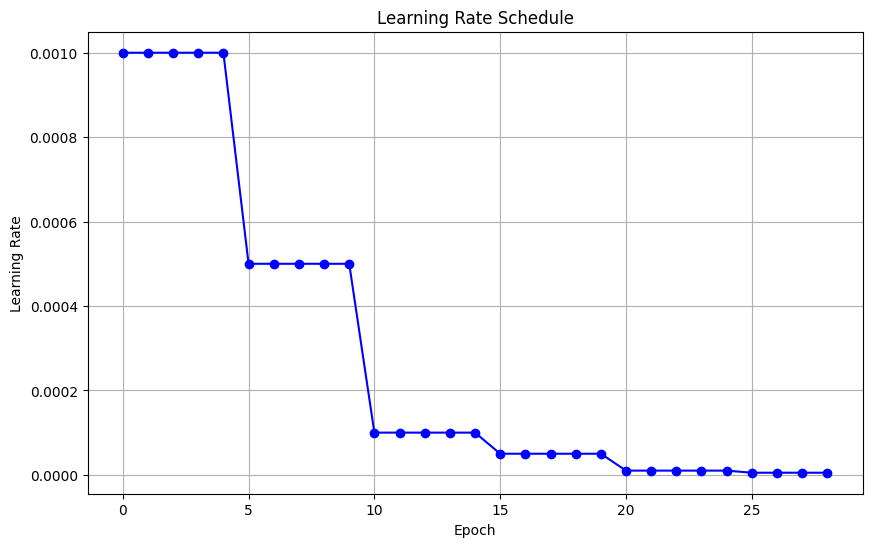

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of epoch numbers from 0 to the number of epochs
epochs = np.arange(epoch)  # Change this to the actual number of epochs

# Calculate the learning rates for each epoch using your lr_schedule function
learning_rates = [lr_schedule(epoch) for epoch in epochs]

# Plot the learning rate schedule
plt.figure(figsize=(10, 6))
plt.plot(epochs, learning_rates, marker='o', linestyle='-', color='b')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [131]:
import tensorflow as tf

# Create an empty list to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the dataset and make predictions
for batch in test:
    inputs, true_batch_labels = batch  # Assuming your dataset provides both inputs and true labels
    predictions = model(inputs, training=False)  # Make predictions using your model

    # Convert the true_batch_labels tensor and predictions tensor to NumPy arrays
    true_batch_labels = true_batch_labels.numpy()
    predictions = predictions.numpy()

    true_labels.extend(true_batch_labels)
    predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
true_labels = np.array([label for label in true_labels])
true_labels = np.argmax(true_labels, axis=1)

In [139]:
cm = confusion_matrix(true_labels,predicted_labels)

In [138]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    plt.show()

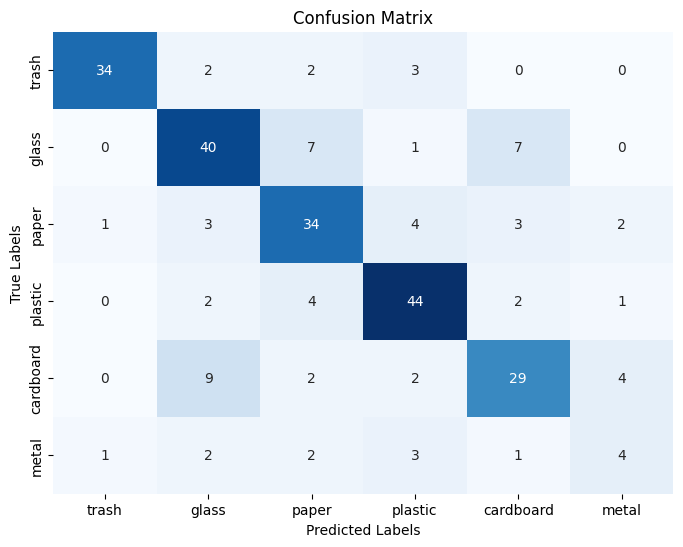

In [186]:
class_names = [ 'trash', 'glass','paper','plastic' , 'cardboard', 'metal']
plot_confusion_matrix(cm, class_names)

# Load the model

In [153]:
from tensorflow.keras.models import load_model
model.save(os.path.join('drive/MyDrive/projects/models', 'Garbage___model.h5'))